In [307]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import sys
import urllib.request
from google.colab import files


In [318]:
client_id = "CPVW7YCGr2hf9gEz_kA0"        # api 써넣기
client_secret = "LzETXT6Tw6"
url = "https://openapi.naver.com/v1/datalab/search";

body = "{\"startDate\":\"2017-01-01\",\"endDate\":\"2017-04-30\",\"timeUnit\":\"month\",\"keywordGroups\":[{\"groupName\":\"한글\",\"keywords\":[\"한글\",\"korean\"]},{\"groupName\":\"영어\",\"keywords\":[\"영어\",\"english\"]}],\"device\":\"pc\",\"ages\":[\"1\",\"2\"],\"gender\":\"f\"}";


# 함수
def df_search(keyword, details, stardate, enddate, ages, gender, device = 'mo', timeunit = 'date'):
# 검색어
keyword = ['멜로가체질', '천우희', '패션']    # keyword list  
details = [['멜로가체질'], ['천우희'], ['패션', '옷', '블라우스']] # 세부검색  
startdate = '2019-01-01'              # 시작날짜 형식:2022-01-03  
enddate = '2020-01-01'                # 종료날짜  
device = 'pc'                         # 검색도구 pc:pc, mo:모바일 미입력시 전체  
timeunit = 'date'                     # 시간단위 date:일간, week:주간, month:월간  
ages = ['1','2','3']                  # 연령대 1:0~12, 2:13~18, 3:19~24, 4:25~29, 5:30~34, 6:35~39, 7:40~44, 8:45~49, 9:50~54, 10:55~59, 11:60~ 미입력시 전체  
gender = 'f'                          # 성별 m:남, f:여 미입력시 전체

In [321]:
# 검색어
keyword = ['멜로가체질', '천우희', '패션']    # keyword list
details = [['멜로가체질'], ['천우희'], ['패션', '옷', '블라우스']] # 세부검색
startdate = '2019-01-01'              # 시작날짜 형식:2022-01-03
enddate = '2020-01-01'                # 종료날짜
device = 'pc'                         # 검색도구 pc:pc, mo:모바일 미입력시 전체
timeunit = 'date'                     # 시간단위 date:일간, week:주간, month:월간
ages = ['1','2','3']                  # 연령대 1:0~12, 2:13~18, 3:19~24, 4:25~29, 5:30~34, 6:35~39, 7:40~44, 8:45~49, 9:50~54, 10:55~59, 11:60~ 미입력시 전체
gender = 'f'                          # 성별 m:남, f:여 미입력시 전체


In [322]:
def df_search(keyword, details, stardate, enddate, ages, gender, device = 'mo', timeunit = 'date'):
  body = "{\"startDate\":\"2017-01-01\",\"endDate\":\"2017-04-30\",\"timeUnit\":\"month\",\"keywordGroups\":[{\"groupName\":\"한글\",\"keywords\":[\"한글\",\"korean\"]},{\"groupName\":\"영어\",\"keywords\":[\"영어\",\"english\"]}],\"device\":\"pc\",\"ages\":[\"1\",\"2\"],\"gender\":\"f\"}";
  body_json = json.loads(body)
  body_json['startDate'] = startdate
  body_json['endDate'] = enddate
  body_json['timeUnit'] = timeunit
  body_json['device'] = device
  body_json['ages'] = ages
  body_json['gender'] = gender

  body_json['keywordGroups'] = []
  for i in range(len(keyword)):
    body_json['keywordGroups'].append( {'groupName': f'{keyword[i]}', 'keywords': details[i]} )
  body = json.dumps(body_json, ensure_ascii=False)


  request = urllib.request.Request(url)
  request.add_header("X-Naver-Client-Id",client_id)
  request.add_header("X-Naver-Client-Secret",client_secret)
  request.add_header("Content-Type","application/json")
  response = urllib.request.urlopen(request, data=body.encode("utf-8"))
  rescode = response.getcode()
  if(rescode==200):
      response_body = response.read()
      response_data = response_body.decode('utf-8')
  else:
      print("Error Code:" + rescode)

  result = json.loads(response_data)
  df = pd.DataFrame()

  # Iterate through each item in the 'results' list
  for item in result['results']:
      item_df = pd.DataFrame(item['data']).set_index('period')
      item_df.columns = [item['title']]

      # Append this DataFrame to the main DataFrame
      df = pd.concat([df, item_df], axis=1)

  df.fillna(0, inplace = True)
  df.reset_index(inplace=True)

  df['period'] = pd.to_datetime(df['period'])
  df.sort_values('period', inplace=True)
  df = df.reset_index(drop = True)

  return df


# 전처리

In [361]:
raw_dramalist = pd.read_csv('/content/1923_dramalist.csv').iloc[:,1:]
rate = pd.read_csv('/content/rate.csv')
meta = pd.read_csv('/content/미니시리즈 전처리1.csv')
brand = pd.read_csv('/content/배우브랜드.csv')

raw_dramalist.loc[raw_dramalist['작품명'] == '멀리서 보는 푸른 봄', '작품명'] = '멀리서 보면 푸른 봄' # 오타 정제
rate['시청률'] = rate['시청률'].str.replace('\[\d+\]', '', regex=True).str.replace('-', '') # 시청률 정제
rate['시청률'] = pd.to_numeric(rate['시청률'])
rate.loc[rate['시청률'] > 50, '시청률'] = [1.1167, 6.39]

# 분석

## 시청률 추이

In [363]:
rate_list = rate['작품명'].unique().tolist() # 348개
drama_list = raw_dramalist.loc[raw_dramalist['작품명'].isin(rate_list)]
drama_list['방송사'] = drama_list['방송사'].str.upper()

<ipython-input-363-39bed501a2b8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drama_list['방송사'] = drama_list['방송사'].str.upper()


In [364]:
drama_list['방송사'].unique() # 'JTBC', 'KBS2', 'tvN', 'MBC', 'TV조선', 'KBS1', 'OCN', 'SBS', 'tvn', 'mbc', 'MBN', '채널A', '투니버스', 'MBC, MBC Every1', 'MBC Every1', 'IHQ , MBN', 'ENA'
drama_list['방송사'] = drama_list['방송사'].str.replace(', MBC EVERY1', '')
# #'JTBC', 'KBS2', 'TVN', 'MBC', 'TV조선', 'KBS1', 'OCN', 'SBS', 'MBN', '채널A', '투니버스', 'MBC EVERY1', 'IHQ , MBN', 'ENA'

jtbc_list = drama_list.loc[drama_list['방송사'] == 'JTBC', '작품명'].tolist()
tvn_list = drama_list.loc[drama_list['방송사'].str.contains('tvn', case = False), '작품명'].tolist()
mbc_list = drama_list.loc[drama_list['방송사'] == 'MBC', '작품명'].tolist()
kbs_list = drama_list.loc[drama_list['방송사'].str.contains('kbs', case = False), '작품명'].tolist()
tv조선_list = drama_list.loc[drama_list['방송사'] == 'TV조선', '작품명'].tolist()
ocn_list = drama_list.loc[drama_list['방송사'] == 'OCN', '작품명'].tolist()
sbs_list = drama_list.loc[drama_list['방송사'] == 'SBS', '작품명'].tolist()
mbn_list = drama_list.loc[drama_list['방송사'].str.contains('mbn', case = False), '작품명'].tolist()
채널a_list = drama_list.loc[drama_list['방송사'] == '채널A', '작품명'].tolist()
ena_lsit = drama_list.loc[drama_list['방송사'] == 'ENA', '작품명'].tolist()

<ipython-input-364-0d2fe40d7ae8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drama_list['방송사'] = drama_list['방송사'].str.replace(', MBC EVERY1', '')


In [365]:
public_list = sbs_list + kbs_list + mbc_list
major_cable = jtbc_list + tvn_list + tv조선_list + ocn_list

In [369]:
def plt_rate(lists):
  plt.figure(figsize = (20, 8))
  a = 1
  for i in lists:
    x = rate[rate['작품명'].isin(i)].groupby('방송일자').sum(numeric_only = False)['시청률'].reset_index()
    plt.plot(x['방송일자'], x['시청률'], label = a)
    a+=1
  plt.legend()
  plt.show()

<ipython-input-366-04b5f63c560e>:5: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  x = rate[rate['작품명'].isin(i)].groupby('방송일자').mean(numeric_only = False)['시청률'].reset_index()
<ipython-input-366-04b5f63c560e>:5: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  x = rate[rate['작품명'].isin(i)].groupby('방송일자').mean(numeric_only = False)['시청률'].reset_index()


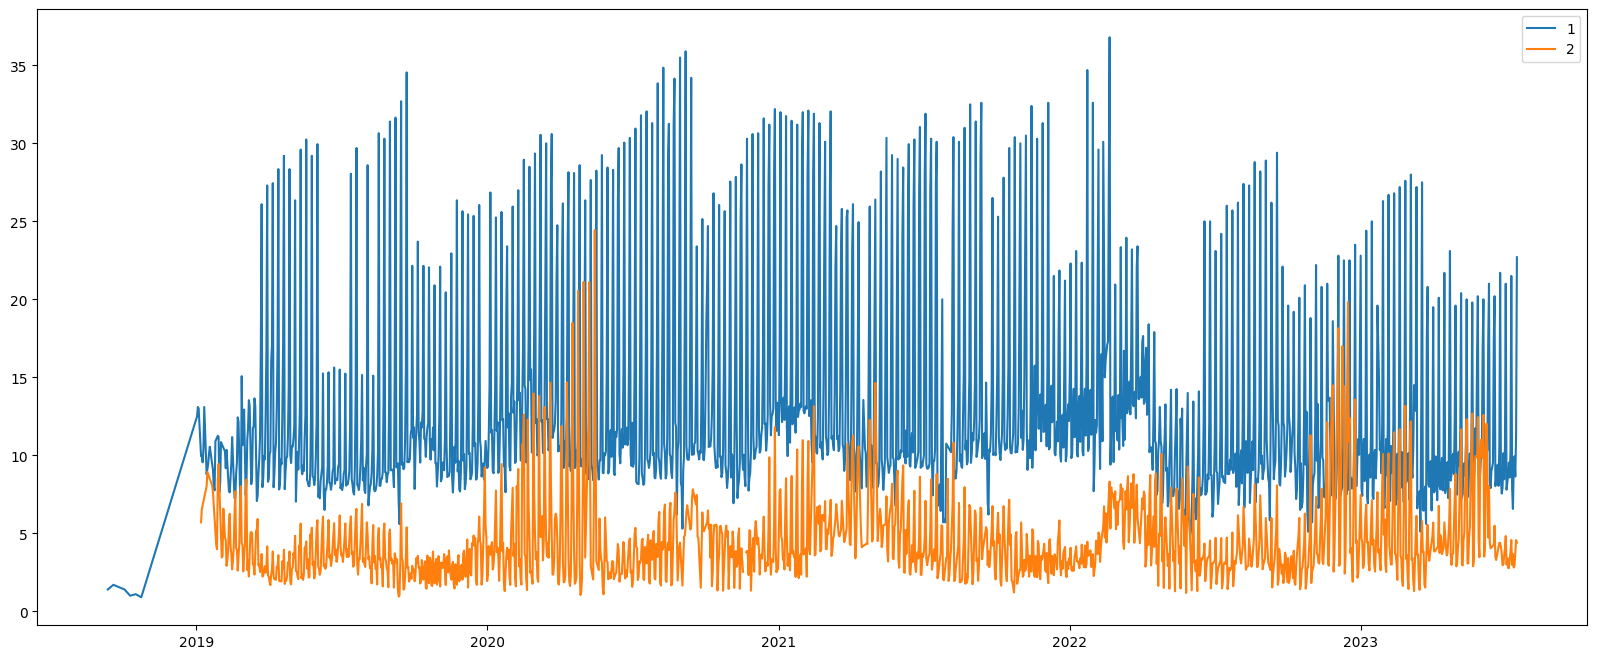

In [367]:
plt_rate([public_list, major_cable])

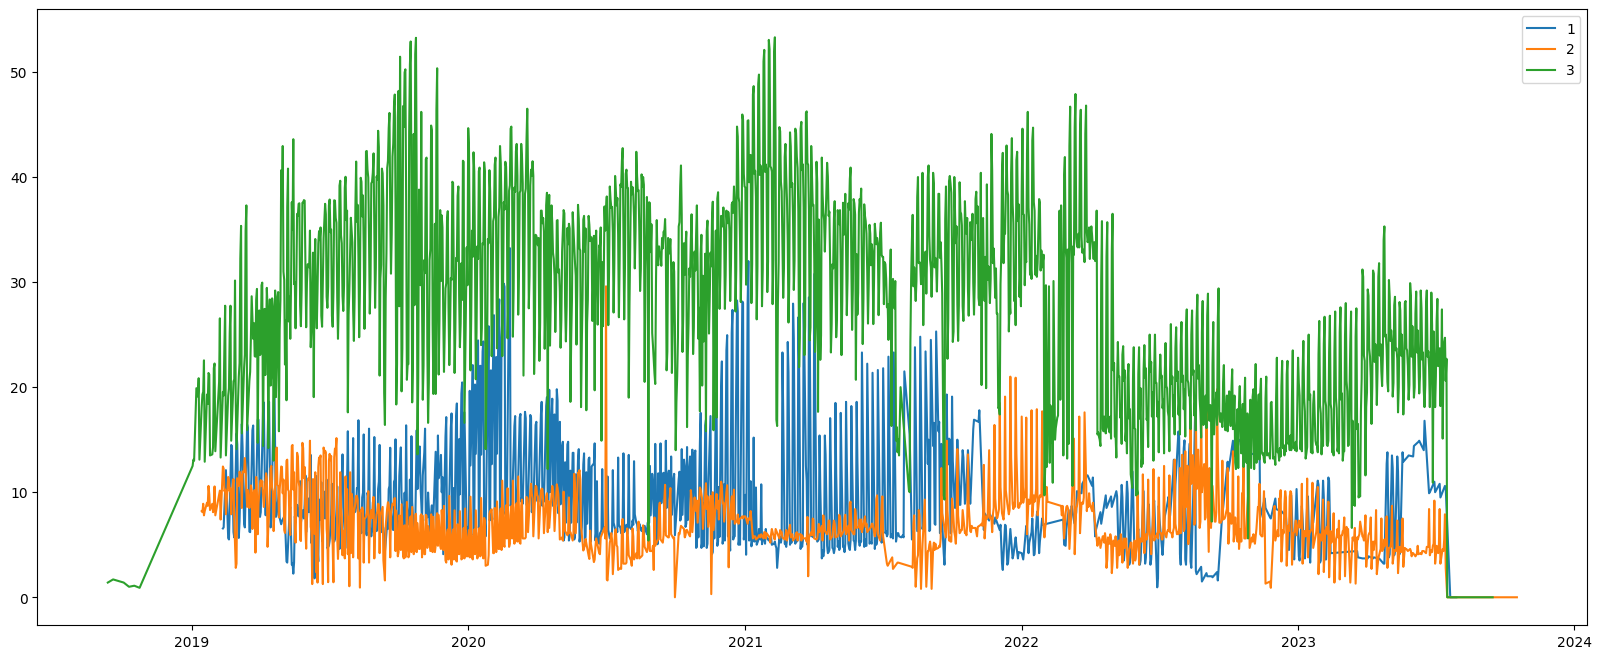

In [282]:
plt_rate([sbs_list, mbc_list, kbs_list])

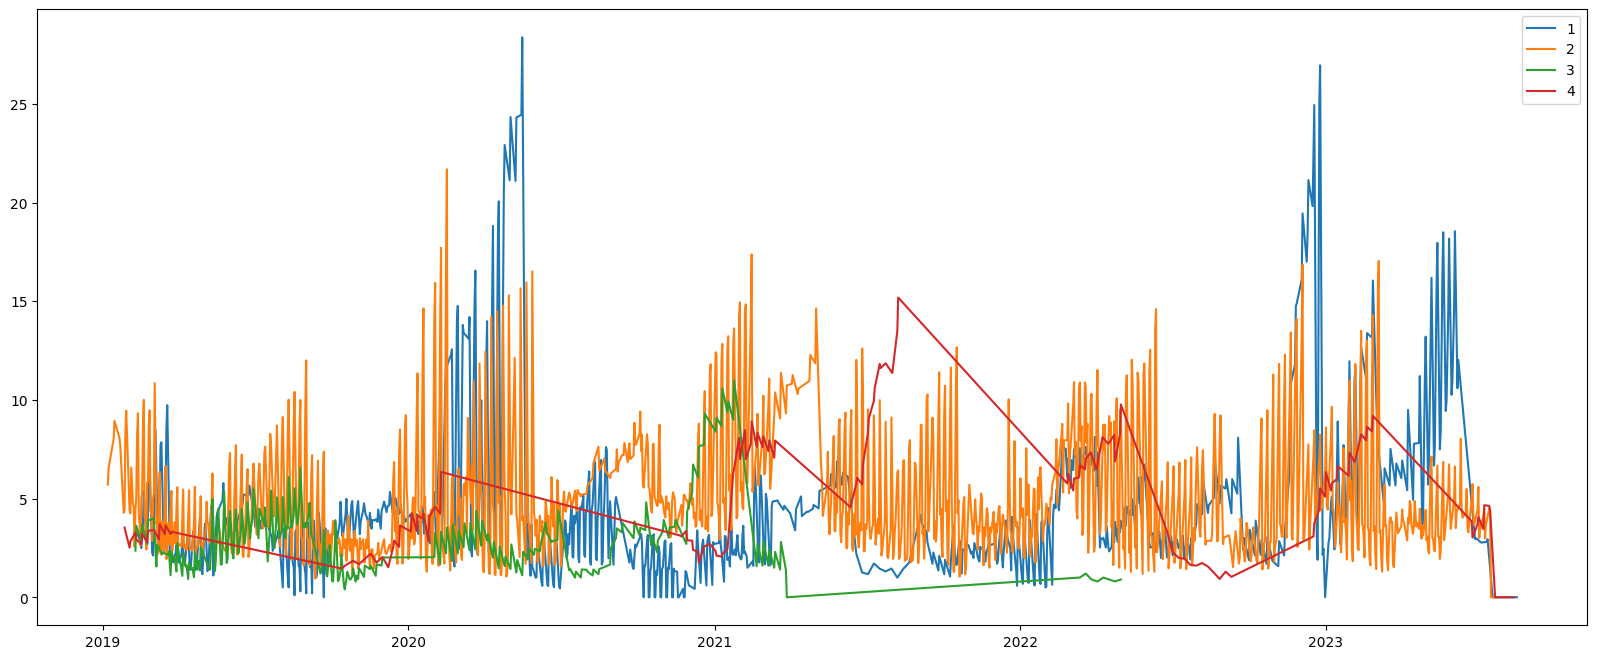

In [370]:
plt_rate([jtbc_list, tvn_list, ocn_list, tv조선_list])

In [288]:
print(meta.columns.tolist())

['작품명', '방송 채널', '방송 횟수', '출연자', '시작일', '종료일', '요일', '금, 월', '금, 토', '수, 목', '월, 화', '일', '토, 일', '시작 시간', ' SF', ' 가족', ' 감성', ' 공포', ' 군대', ' 낭만', ' 느와르', ' 드라마', ' 로맨스', ' 로맨스 드라마', ' 로맨틱 코미디', ' 로코', ' 막장', ' 메디컬', ' 멜로', ' 모험', ' 미스터리', ' 미스터리 수사물', ' 범죄', ' 법률', ' 복수', ' 블록버스터', ' 비즈니스', ' 사극', ' 서스펜스', ' 서스펜스 추리', ' 성장', ' 수사', ' 스릴러', ' 스포츠', ' 심리', ' 액션', ' 엑소시즘', ' 연속극', ' 오피스', ' 음악', ' 음악 드라마', ' 의학', ' 일상물', ' 전쟁', ' 정치', ' 좀비', ' 첩보', ' 추리물', ' 캠퍼스', ' 코미디', ' 코믹', ' 판타지', ' 학교', ' 한의학', ' 형사물', ' 휴머니즘', ' 휴먼', 'SF', '가족', '경제', '공포', '금융', '드라마', '로맨스', '로맨틱', '로맨틱 코미디', '로맨틱 코미디 드라마', '로맨틱 판타지', '메디컬', '멜로', '멜로 로맨스 코미디', '미스터리', '미스터리 멜로', '미스터리 스릴러', '범죄', '법률', '법률 드라마', '법정', '사극', '서스펜스', '서스펜스 멜로', '스릴러', '스포츠', '스포츠 드라마', '시대극', '액션', '의학', '정치', '청춘', '청춘 드라마', '청춘 성장', '추리', '캠퍼스', '코미디', '코믹', '코믹 미스터리 사극 드라마', '클래식', '타임 크로싱', '판타지', '판타지 로코 드라마', '판타지 액션 로맨스', '프라이빗 오피스 멜로', '학원물 로맨스', '휴머니즘', '휴먼', ' ', ' 강기영 ', ' 강미나', ' 강미나 ', ' 강민아', ' 강민혁 ', ' 강별', ' 강성

In [292]:
mtwt = meta.loc[(meta['월, 화'] == 1) | (meta['수, 목'] == 1)]

In [295]:
mon = meta.loc[meta['월, 화'] == 1, '작품명'].unique().tolist()
wed = meta.loc[meta['수, 목'] == 1, '작품명'].unique().tolist()

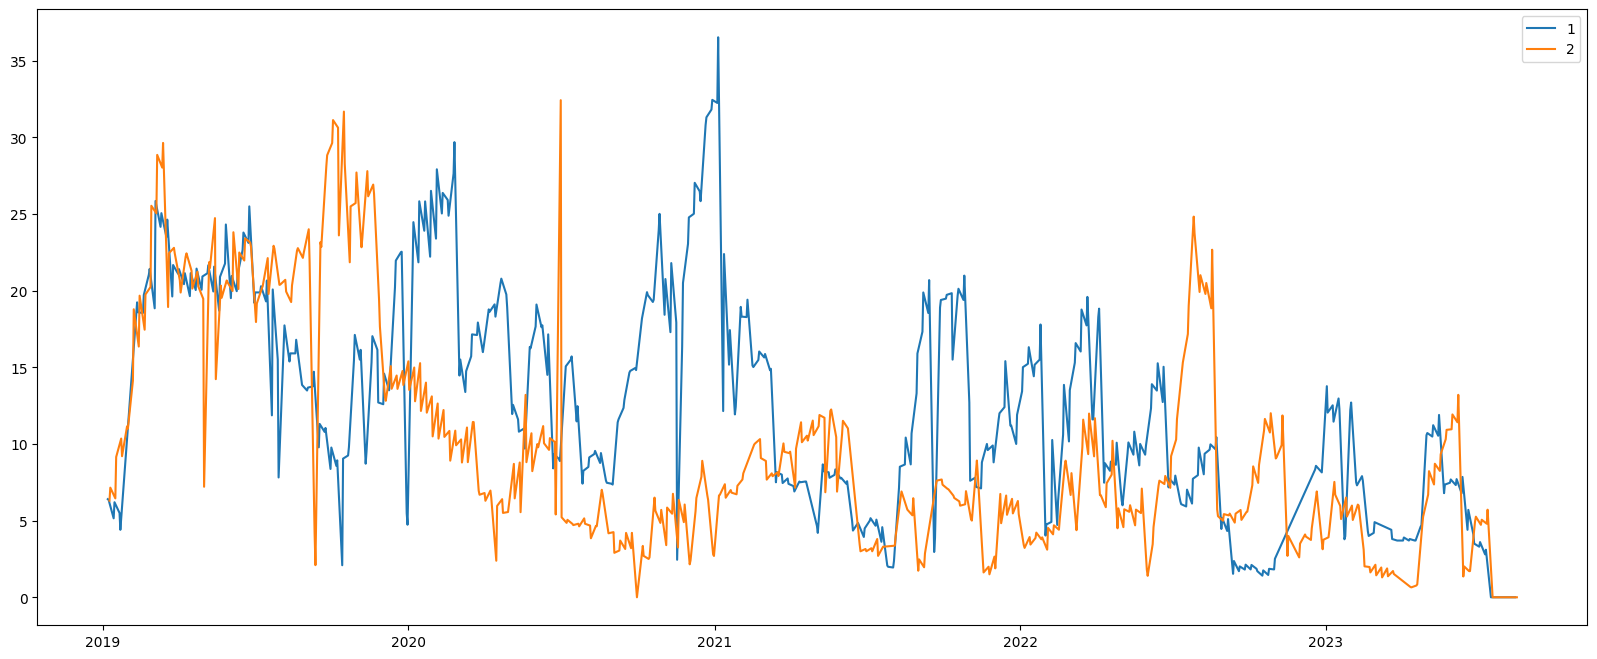

In [296]:
plt_rate([mon, wed])

## 검색량 추이

In [304]:
mon_hit = rate.loc[(rate['시청률'] > 20) & (rate['작품명'].isin(mon)),'작품명'].unique().tolist()
wed_hit = rate.loc[(rate['시청률'] > 20) & (rate['작품명'].isin(wed)),'작품명'].unique().tolist()

In [324]:
x = df_search(mon_hit, [['낭만닥터', '김사부', '낭만닥터 김사부 2', '김사부 2'], ['펜트하우스', '펜하']], '2019-01-01', '2022-01-01',  ['1', '2', '3','4'], 'f')

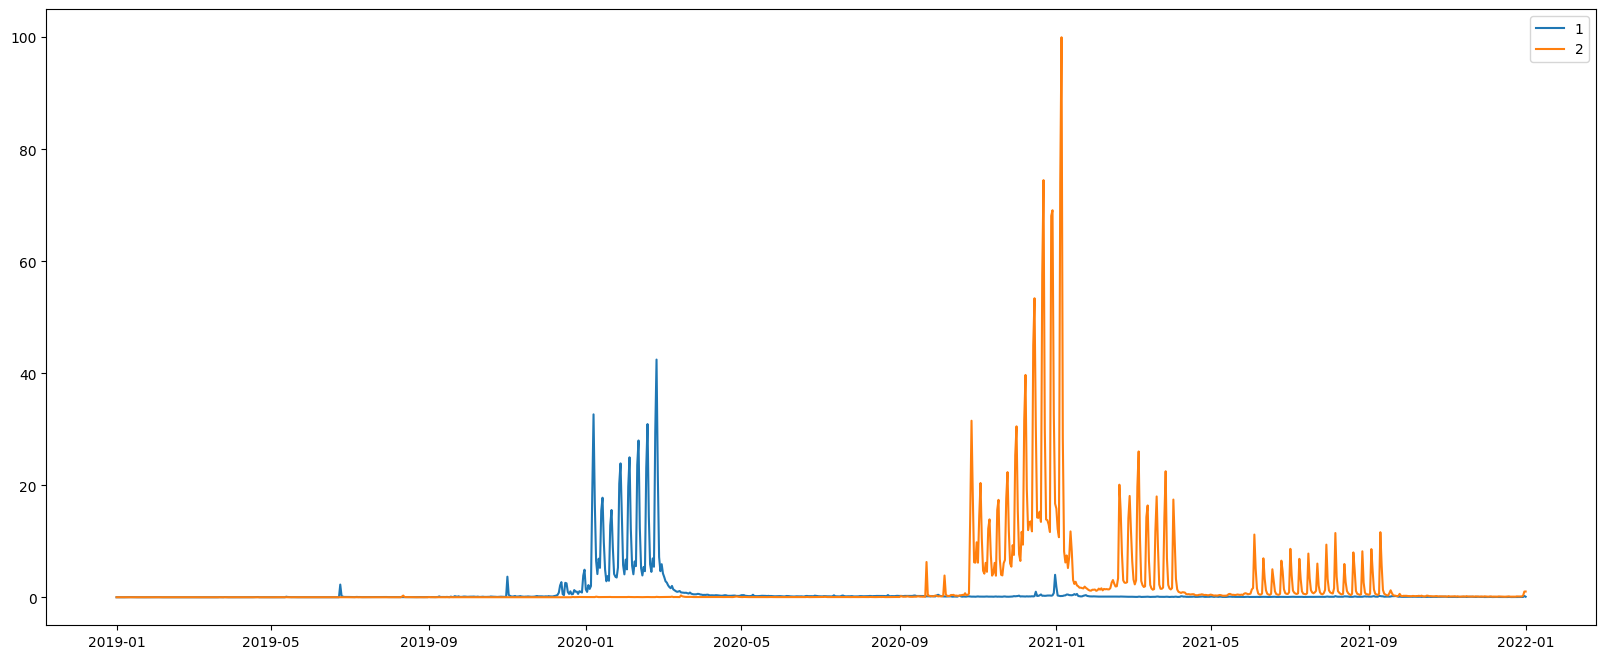

In [329]:
plt.figure(figsize = (20, 8))
plt.plot(x['period'], x['낭만닥터 김사부 2'], label = 1)
plt.plot(x['period'], x['펜트하우스'], label = 2)
plt.legend()
plt.show()

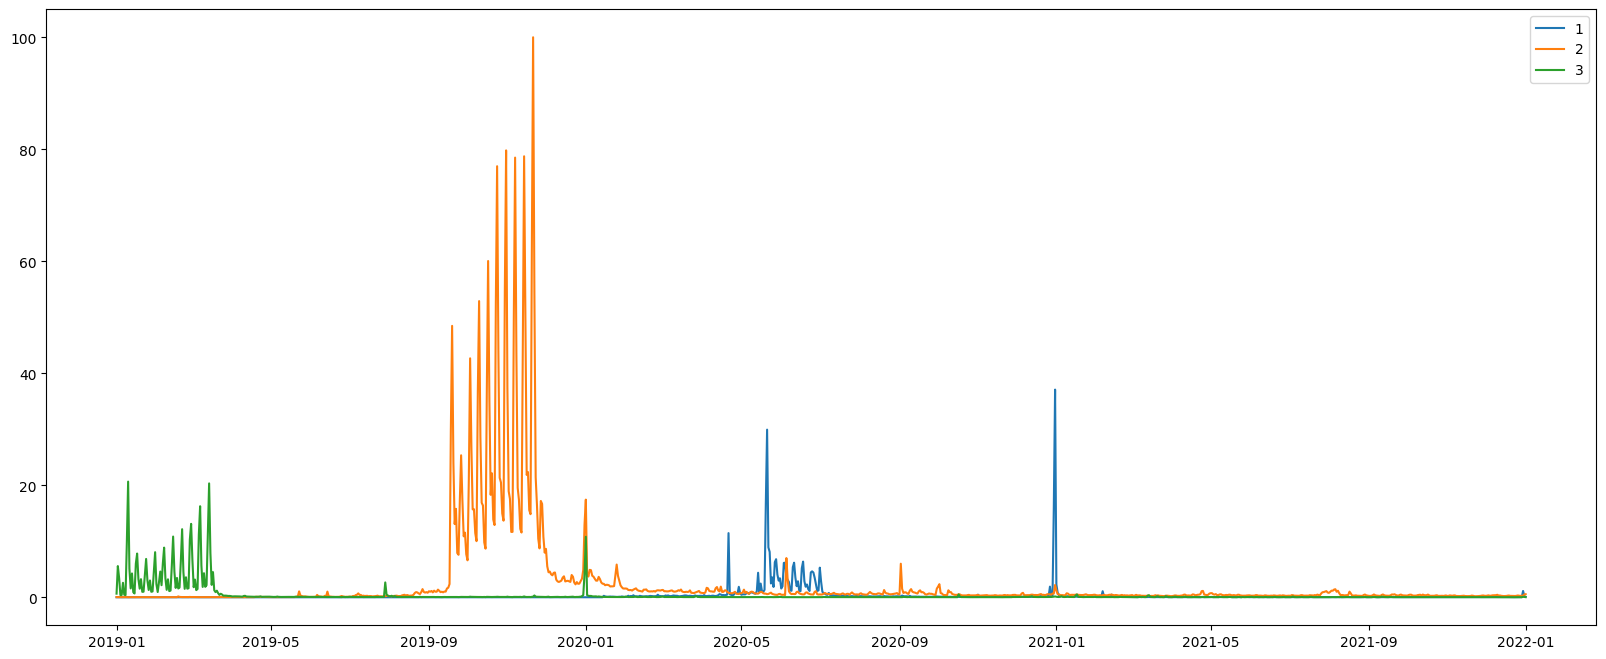

In [334]:
x = df_search(wed_hit, [['꼰대인턴'], ['동백꽃 필 무렵'], ['왜그래 풍상씨']], '2019-01-01', '2022-01-01',  ['1', '2', '3','4'], 'f')
plt.figure(figsize = (20, 8))
plt.plot(x['period'], x['꼰대인턴'], label = 1)
plt.plot(x['period'], x['동백꽃 필 무렵'], label = 2)
plt.plot(x['period'], x['왜그래 풍상씨'], label = 3)
plt.legend()
plt.show()

In [332]:
x

,period,낭만닥터 김사부 2,펜트하우스
0,2019-01-01,0.00000,0.03669
1,2019-01-02,0.00000,0.02721
2,2019-01-03,0.00000,0.02476
3,2019-01-04,0.00000,0.02691
4,2019-01-05,0.00000,0.01804
...,...,...,...
1092,2021-12-28,0.02935,0.25626
1093,2021-12-29,0.03058,0.26941
1094,2021-12-30,1.13024,0.28684
1095,2021-12-31,0.19663,0.50701
